# Computer Science 358: Independent Research / Machine Learning for Meteorology
_Rachel Frantsen, 2016, and Dr. Matthew Richey_

The following program is the result of experimentation with the application of machine learning (ML) techniques to meteorological radar. Currently, numerical weather prediction (NWP) is the dominant technique for predicting weather patterns, employing mathematical models based on fluid dynamics and thermodynamics. Investigations into meteorological applications of ML have been few and far between, due to ML's recent emergence as a potentially useful tool.

Current NWP models are effective thanks to decades of development when there was no feasible alternative, and ML approaches may need the same attention and development in order to become competitively useful - however we will never know unless we take the time to develop the techniques.

This independent research seeks to investigate the potential of ML techniques in meteorological applications and develop a framework for asking questions about its effectiveness.

## Receiving data from NOAA

I tried out several sources of weather data and techniques for fetching them - including Weather Underground, the National Oceanic and Atmospheric Administration's (NOAA) Climate Data archives, and the NOAA radar system. Wunderground provided a convenient API for accessing weather information such as temperature and rainfall amount at particular observation sites, but it was more difficult to recieve radar. The Climate Data archives provided a large amount of data in bulk, but it was inconvenient to obtain and to parse. My work with NOAA radar was most productive so that is what is used in this demonstration.

In order to retrieve the data, I set up a scheduled job using Cron on a lab computer to run the following script every three hours, since it took about three hours on average to run the script each time and there was about only about four recent hours of data available online at a time.

As evident in the script, I pulled six typs of radar from 16 radar stations from the inland United States, varying the time between each download in order to limit the load on the NOAA servers, and then logged the time the download was completed. At the time of my writing this, there had been a total of 481 full downloads. 

_After recieving data from NOAA onto RNS 202-20, I loaded them onto my local machine to use on the Jupyter Ipython 3.6 server that I set up there, using an rsync command._

In [1]:
import os, sys
from PIL import Image
import numpy as np
import pandas as pd
from IPython import display
%matplotlib inline
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import random

## Converting images to data

The following cell is a function (translate_n0r) that converts a N0R or N0S radar image to a list of dBZ values.

> "dBZ" stands for decibels relative to _Z_, a factor of reflectivity relative to that of a 1 mm drop of rain. The abbreviation can be thought of simply as _reflectivity_, and it directly corresponds to a specific intensity in precipitation. For example, 10 dBZ directly corresponds to light mist, and 50 dBZ corresponds to heavy rain.

The function gets RGB values from the palette of the GIF-formatted radar image, then uses a dictionary to translate the RGB values into single dBZ data points.

In [2]:
def translate_n0r(img, palette):
    standardizedImg = []
    known_colors = {(0, 142, 0): 30,
     (1, 159, 244): 10,
     (1, 197, 1): 25,
     (2, 253, 2): 20,
     (3, 0, 244): 15,
     (4, 233, 231): 5,
     (152, 84, 198): 70,
     (212, 0, 0): 55,
     (229, 188, 0): 40,
     (248, 0, 253): 65,
     (253, 0, 0): 50,
     (253, 149, 0): 45,
     (253, 248, 2): 35,
     (253, 253, 253): 75}
    for j in range(len(img)):
        colorNum = img[j]
        r,g,b = palette[colorNum*3+0], palette[colorNum*3+1], palette[colorNum*3+2]
        if (r,g,b) in known_colors:
            standardizedImg.append(known_colors[(r,g,b)])
        else:
            standardizedImg.append(0)
    return standardizedImg         

## Pulling data from the file system

The following function reads in files from my local radar repository and outputs two multidimensional Python arrays - one which is the input data for training, and one which is the predicted result for that data. There are multiple rows in each, depending on the "num_samples" paramter. Along the way, we resize each image, in order to reduce the number of pixels we must create models for.

Note that while our objective is to train ML models, one for each pixel, I am using the entire image to train each pixel. The hope is that the motion of the weather nearby will contribute to the prediction of each individual spot. This is an attempt to avoid the problems that I ran into when trying to predict temperature data by using data from only one observation station.

In [3]:
def import_data(locations, radar_type, sample_size, num_samples_initial, frame_delay=0, dimension=20):
    X_output = []  
    to_Y = []
    for location in locations:
        cur_path = "radar_archive/radar.weather.gov/ridge/RadarImg/"+radar_type+"/"+location
        all_files = os.listdir(cur_path)[1:]
        num_samples = min(num_samples_initial, len(all_files)-sample_size-frame_delay-1)
        for i in range(num_samples):
            files_subset = all_files[i:sample_size+i+1]
            to_output = []
            for filename in files_subset:
                infileName = cur_path+"/"+filename
                outfileName = cur_path+"/small/"+filename
                im = Image.open(infileName)
                im = im.resize((dimension,dimension))
                to_output.extend(translate_n0r(list(im.getdata()), im.getpalette()))
                im.save(outfileName, "gif")
            to_Y.append(to_output[-dimension**2:])
            X_output.append(to_output[:-dimension**2])
    
    # Rotate Y data
    Y_output = []  
    for i in range(dimension**2):
        short_Y = []
        for j in range(num_samples*len(locations)):
            short_Y.append(to_Y[j][i])
        Y_output.append(short_Y)
    
    return X_output, Y_output
 
to_dataframe, Y_file_vals = import_data(["MPX", "DMX"], "N0R", 30, 2)

Here I transformed the data into a Pandas dataframe so that it would be compatible with Scikit-Learn.

In [10]:
# Create labels for the data
df_columns = []
for i in range(30):
    for j in range(20):
        for k in range(20):
            df_columns.append(str(i)+":"+str(j+1)+","+str(k+1))
            
# Convert to Pandas dataframe
df = pd.DataFrame(to_dataframe, columns=df_columns)
df = df._get_numeric_data()
df.head()

,"0:1,1","0:1,2","0:1,3","0:1,4","0:1,5","0:1,6","0:1,7","0:1,8","0:1,9","0:1,10",...,"29:20,11","29:20,12","29:20,13","29:20,14","29:20,15","29:20,16","29:20,17","29:20,18","29:20,19","29:20,20"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Making the prediction

Here I created an array of models, and each model represents one pixel in an image. Again for each row of the table I am using an array of data from whole images, in this case 30 images, to predict each single pixel.

**WARNING: This cell may take a VERY long time to run!**

In [11]:
pixel_models = []
for i in range(20**2):
    Y_train_pixel = pd.DataFrame(Y_file_vals[i])
    pixel_models.append(Lasso(alpha=100).fit(df, Y_train_pixel))

In [12]:
X_test, Y_test = import_data(["ABR"], "N0R", 30, 1)
df_test = pd.DataFrame(X_test, columns=df_columns)
df_test = df_test._get_numeric_data()
df_test

,"0:1,1","0:1,2","0:1,3","0:1,4","0:1,5","0:1,6","0:1,7","0:1,8","0:1,9","0:1,10",...,"29:20,11","29:20,12","29:20,13","29:20,14","29:20,15","29:20,16","29:20,17","29:20,18","29:20,19","29:20,20"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
predicted_radar = []
for i in range(20**2):
    predicted_pixel_Y = pixel_models[i].predict(df)
    predicted_radar.append(int(predicted_pixel_Y[0]))

## Turning predicted data back into an image

The function save_predicted turns the predicted data into an easily understood visual format, a GIF file just like all the input data. It does this by mapping each predicted value onto a tuple that represents an RGB value, and then saves it as a new image in a designated folder.

In [15]:
def save_predicted(predicted_values, d, newfilename):
    n0r_to_color = {5: (4, 233, 231, 1),
     10: (1, 159, 244, 1),
     15: (3, 0, 244, 1),
     20: (2, 253, 2, 1),
     25: (1, 197, 1, 1),
     30: (0, 142, 0, 1),
     35: (253, 248, 2, 1),
     40: (229, 188, 0, 1),
     45: (253, 149, 0, 1),
     50: (253, 0, 0, 1),
     55: (212, 0, 0, 1),
     65: (248, 0, 253, 1),
     70: (152, 84, 198, 1),
     75: (253, 253, 253, 1),
     0: (0,0,0,0)}
    rgba_image_array = []
    for value in predicted_values:
        rgba_image_array.append(n0r_to_color[value-value%5])
    img = Image.new("RGBA", (d, d), color = (0,0,0,0))
    img.putdata(rgba_image_array)
    img.save(newfilename, transparent = 0)
    
predicted_filenames = ["N0R_ABR_1"]
predicted_filepaths = []
for predicted_filename in predicted_filenames:
    predicted_filepath = "radar_predicted/" + predicted_filename + ".gif"
    predicted_filepaths += [predicted_filepath]
    save_predicted(predicted_radar, 20, predicted_filepath)

## Image example

Here I've compared a predicted image, using models trained over four iterations, with the actual image corresponding with the test dataset, for purposes of illustration.

In [16]:
displayMarkup = 'Predicted {} at {}: <img src="{}" width=50% height=50% style="image-rendering:pixelated">'.format("N0R", "ABR", predicted_filepaths[0])
Y_test_filepath = "radar_archive/radar.weather.gov/ridge/RadarImg/N0R/ABR/small/" + os.listdir("radar_archive/radar.weather.gov/ridge/RadarImg/N0R/ABR/small")[30]
# Y_test_filepath = cur_path + "/small/" + os.listdir(cur_path+"/small")[-2]
displayMarkup += '<br>Actual {} at {}: <img src="{}" width=50% height=50% style="image-rendering:pixelated">'.format("N0R", "ABR", Y_test_filepath)
display.HTML(displayMarkup)

# Calculating accuracy

To create a measure of accuracy the following function calculates both Mean Squared Error (MSE) and Euclidian Error.

In [24]:
def mse_euclidian_error(predicted, calculated):
    from math import sqrt
    squared_total_vals = 0.0
    length = len(calculated)
    for i in range(length):
        squared_total_vals += (predicted[i] - calculated[i])**2
    mse = squared_total_vals/length
    euclidian_distance = sqrt(squared_total_vals)/length
    return mse, euclidian_distance

im = Image.open(Y_test_filepath)
Y_file_vals = translate_n0r(list(im.getdata()), im.getpalette())
print(mse_euclidian_error(Y_file_vals, predicted_radar))

(7.965, 0.14111165791670083)


In [25]:
print(mse_euclidian_error(Y_file_vals, Y_file_vals))

(0.0, 0.0)


In [26]:
random_1 = []
random_2 = []
for i in range(400):
    random_1.append(random.randrange(0,76))
    random_2.append(random.randrange(0,76))
print(mse_euclidian_error(random_1, random_2))

(1037.3425, 1.6103900924931203)


## Comparing results of different training set sizes

The function error_from_num_iterations is all the code we have demonstrated so far collected to return an error rate. The parameter num_iterations specifies the number of rows from each of the stations MPX, DMX, ABR, OAX, and ILX to use in model training. The example below compares the accuracy of five total rows versus ten. It is a small amount, but I felt that I would need greater computing power to be able to scale this very much further.

**WARNING: THE FOLLOWING CELL ALWAYS AN TAKES EXTREMELY LONG TIME TO RUN**

In [44]:
def error_from_num_iterations(num_iterations):
    to_dataframe, Y_file_vals = import_data(["MPX", "DMX", "ABR", "OAX", "ILX"], "N0R", 30, num_iterations)

    # Create labels for the data
    df_columns = []
    for i in range(30):
        for j in range(20):
            for k in range(20):
                df_columns.append(str(i)+":"+str(j+1)+","+str(k+1))

    # Convert to Pandas dataframe
    df = pd.DataFrame(to_dataframe, columns=df_columns)
    df = df._get_numeric_data()

    # Train pixel models
    pixel_models = []
    for i in range(20**2):
        Y_train_pixel = pd.DataFrame(Y_file_vals[i])
        pixel_models.append(Lasso(alpha=100).fit(df, Y_train_pixel))

    X_test, Y_test = import_data(["LSX"], "N0R", 30, 1)
    df_test = pd.DataFrame(X_test, columns=df_columns)
    df_test = df_test._get_numeric_data()

    predicted_radar = []
    for i in range(20**2):
        predicted_pixel_Y = pixel_models[i].predict(df)
        predicted_radar.append(int(predicted_pixel_Y[0]))

    predicted_filenames = ["N0R_ABR_1"]
    predicted_filepaths = []
    for predicted_filename in predicted_filenames:
        predicted_filepath = "radar_predicted/" + predicted_filename + ".gif"
        predicted_filepaths += [predicted_filepath]
        save_predicted(predicted_radar, 20, predicted_filepath)

    im = Image.open(Y_test_filepath)
    Y_file_vals = translate_n0r(list(im.getdata()), im.getpalette())
    mse, euc = mse_euclidian_error(Y_file_vals, predicted_radar)
    return euc

error_by_iterations = []
# Warning: the number of rows you enter as the range will be multiplied by 5! 1 is not a small difference!
for i in [1, 2, 4, 6]:
    ls = []
    ls.append(i)
    ls.append(error_from_num_iterations(i))
    error_by_iterations.append(ls)
error_by_iterations

[[1, 0.12318684994754919],
 [2, 0.12234684303242156],
 [4, 0.12278029157808674],
 [6, 0.12116620816052634]]

## Visualizaton of error rates

According to the visualization below, it is easy to see that the error rates of the prediction are decreasing even over elementary increases to the size of the training set. With even more computing power we would be able to see a greater increase in accuracy.

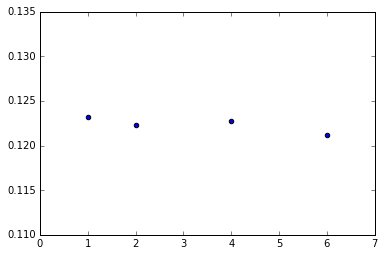

In [46]:
plot_x = []
plot_y = []
for i in range(len(error_by_iterations)):
    plot_x.append(error_by_iterations[i][0])
    plot_y.append(error_by_iterations[i][1])
        
plot_x = np.array(plot_x)
plot_y = np.array(plot_y)
plt.scatter(plot_x, plot_y)

# Conclusion and future work

I found that larger training sizes actually did improve the predictive ability of the model we used. However, the research effort was constrained by the very same issues that hamper NWP prediction techniques at large scale - the availability of computing power.

In future research, we can ask questions about the effectiveness of different models in relation to one another, as well as the ability of ML techniques to predict further into the future. It would also be a good idea to migrate the operation to a remote server with greater computing capability, or possibly adapt the project to a parallel computing platform to take advantage of a Beowulf cluster.